#  Project 1 - Bee Subspecie Classification (logistic regression vs neural network approach) 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Testing for TPU



In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.8.2
Running on TPU  ['10.64.151.218:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.64.151.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.64.151.218:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


### Import relevant libraries

In [3]:
import sys
from time import time
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import plotly.express as px
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
#to load matlab mat files
from scipy.io import loadmat

size = 100 #Desired size of columns and rows of each image (size*size) - We also used 50x50 and 256x256 for some tests
img_class_threshold = 500 #Minimum amount of images from each class

## PART 2: Load data

In [4]:
# -----------------------------------
# Loading of the data from the .csv

ds = pd.read_csv('/content/drive/MyDrive/oversampled_balanced_ml_data.csv')
features=ds['features']
y1=ds['class']

# -----------------------------------
# Mapping the labels to integers from the dictionary

y2 = {'Italian honey bee':1,'Carniolan honey bee':2, 'Russian honey bee':3,'1 Mixed local stock 2':4}
y = (pd.Series(y1)).map(y2)
y = np.array(y)
y = np.reshape(y, (-1, 1))

#print(type(y))
#print(y)

# -----------------------------------

n_examples = features.shape[0]
feature_size = size*size
X = np.empty((n_examples,feature_size), float)
for idx,f in enumerate(features):
        arr_f = np.fromstring(f, dtype=float, sep=' ')
        arr_f = np.reshape(arr_f, (1,arr_f.shape[0]))
        X[idx,:] = np.copy(arr_f)
#X = np.copy(arr)
#print(y.shape)
#print(X.shape)

# -----------------------------------
# Split of the data
# 3 Methods used - choose 1 only

# 80%/20% Holdout Method 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 70%/30% Holdout Method 

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# 3 way split: Train/Dev/Test Sets
# As we use a small data set (up to 10000 examples) we will use this division: 60%/20%/20%
# One approach to dividing the dataset into train, test, cv with 0.6, 0.2, 0.2 is to use the train_test_split method twice like below.

#X, X_test, y, y_test = train_test_split(X,y,test_size=0.2,train_size=0.8)
#X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size = 0.25,train_size =0.75)

# -----------------------------------

# Informations about the shapes
print('X_train.shape: ' + str(X_train.shape))
print('y_train.shape: ' + str(y_train.shape))
print('X_test.shape: ' + str(X_test.shape))
print('y_test.shape: ' + str(y_test.shape))

# For when using the 3 way split:

#print('X_cv.shape: ' + str(X_cv.shape))
#print('y_cv.shape: ' + str(y_cv.shape))

# -----------------------------------

X_train.shape: (2004, 10000)
y_train.shape: (2004, 1)
X_test.shape: (501, 10000)
y_test.shape: (501, 1)


# PART 3: Neural Network training

In [5]:
# Sigmoid FUNCTION from the classes lab - Our choice for the activation function
def sigmoid(z):
    """
    return the sigmoid of z
    """
    gz= 1/(1+np.exp(-z))

    return gz

In [6]:
# Cost FUNCTION for the nn from the classes lab but adapted to our case 
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda):
    """
    nn_params contains the parameters unrolled into a vector
    
    compute the cost and gradient of the neural network
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J=0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
    
    cost = 1/m* J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:] # 1 X 401
        a1i = a1[i,:] # 1 X 26
        a2i =a2[i,:] # 1 X 10
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T)))
        grad1= grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        
    grad1 = 1/m * grad1
    grad2 = 1/m*grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2, reg_J, grad1_reg, grad2_reg

In [7]:
#Computes the gradient of sigmoid function (from classes lab)
def sigmoidGradient(z):
    """
    computes the gradient of the sigmoid function
    """
    sigmoid = 1/(1 + np.exp(-z))
    
    return sigmoid *(1-sigmoid) 

In [8]:
#To get the initial weights of a layer (from classes lab)
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

In [9]:
# Defining some hyper-parameters useful for the initialization of the weights

input_layer_size  = 10000 # as we are using 100x100 image size
hidden_layer_size = 9 # using 20 neurons
num_labels = 4 # for the 3 classes prediction - we also did tests with 2 and 4 classes

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

In [10]:
# Using this optimization alghoritm adapted from class to our case
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        cost, grad1, grad2 = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)[3:]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
    
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history

In [11]:
#@title Default title text
# Choosing some hyper-parameters useful for applying the optimization alghoritm
alpha= 0.03 #learning rate
num_iters=5000 #number of iterations
Lambda=0.001 #Regularization amount 

nnTheta, nnJ_history = gradientDescentnn(X_train,y_train,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels)

Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

In [12]:
#With this function we make the predictions using the already trained NN

def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    """
        #number of training examples
    m = X.shape[0]
        
    # add an extra column of 1´s corresponding to xo=1
    X = np.append(np.ones((m,1)),X,axis=1)
    
    #Compute the output of the hidden layer (with sigmoid activation functions)
    z1=np.dot(X, Theta1.T)  #Inputs to the hidden layer neurons
    a1=sigmoid(z1)  #Outputs  of the hidden layer neurons
    
    #Add a column of ones
    a1 = np.append(np.ones((m,1)),a1, axis=1)
    
    #Compute the output of the output layer (with sigmoid activation functions)
    z2=np.dot(a1, Theta2.T) #Inputs to the output layer neurons
    a2=sigmoid(z2)  #Outputs  of the output layer neurons
    
    return np.argmax(a2,axis=1)+1

In [20]:
# Getting predictions from the model to obtain the metrics and performance measures

pred3 = predict(Theta1, Theta2, X_train)
m = X_train.shape[0]
#This is the training set accuracy useful for comparing how well the NN is training
print("Training Set Accuracy:",sum(pred3[:,np.newaxis]==y_train)[0]/m*100,"%") 

Training Set Accuracy: 60.62874251497006 %


In [21]:
# Getting predictions from the model to obtain the metrics and performance measures

t0 = time()
pred3 = predict(Theta1, Theta2, X_test)
test_time = time() - t0
m = X_test.shape[0]
#This is the testing set accuracy useful for comparing how well the NN is generalizing new examples
print("Testing Set Accuracy:",sum(pred3[:,np.newaxis]==y_test)[0]/m*100,"%")
print("Test time:  %0.3fs" % test_time)

Testing Set Accuracy: 59.2814371257485 %
Test time:  0.032s


In [22]:
# Confusion Matrix

pred3 = np.array(pred3)
pred3 = np.reshape(pred3, (-1, 1))
print("----------------------")
print("Confusion Matrix:")
cm = confusion_matrix(y_test, pred3) #,normalize='all')
print(cm)
print("----------------------")
display_labels = ['Italian', 'Carniolan', 'Russian', 'Mixed']

# This graphically computes the confusion matrix for better visualization

print("Confusion Matrix Display:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
disp.plot()

plt.show()

----------------------
Confusion Matrix:


ValueError: ignored

In [19]:
# Classification report - here we get a lot of metrics such as the precision, recall and f1-score as well as some averages

target_names = ['Italian honey bee', 'Carniolan honey bee', 'Russian honey bee', '1 Mixed Local Stock 2']
print("Classification Report:")
print(classification_report(y_test, pred3, target_names=target_names))

Classification Report:


ValueError: ignored

Text(0.5, 1.0, 'Cost function using Gradient Descent')

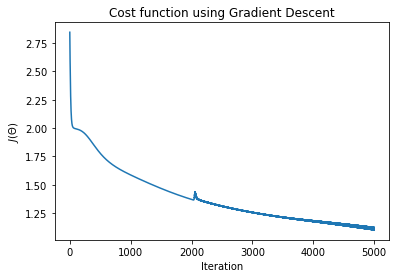

In [17]:
# Plot the cost function evolution during training.
#In order to say learning has finished, the cost function has to converge to a flat rate
plt.plot(nnJ_history)  #
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")